## **DOWLOAND AND ANALYSIS DATASET**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import copy
import pandas as pd
import datetime
import seaborn as sns
from importlib import reload

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,CSVLogger
from tensorflow.keras.utils import plot_model

import torch
from statistics import mean

my_path = '/content/drive/MyDrive/TAREA_4'
%cd '/content/drive/MyDrive/TAREA_4'

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4


In [ ]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1m7ulaF6vRdJILJHNzkvV3okSiMfFngiV' -O y_train.npy
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qASMDexGyrDKfb7egPY1F1JNO3mPyVWx' -O X_train.npy
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VzSNV6XzIRHSYqKODQyy5xg8iiKEWoSl' -O X_test.npy

--2023-11-07 22:35:04--  https://docs.google.com/uc?export=download&id=1m7ulaF6vRdJILJHNzkvV3okSiMfFngiV
Resolving docs.google.com (docs.google.com)... 142.250.107.139, 142.250.107.113, 142.250.107.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aseapnev20kb05ifpu4rj3t7iv6s5nsr/1699396500000/11849440450678359784/*/1m7ulaF6vRdJILJHNzkvV3okSiMfFngiV?e=download&uuid=9c7aab2f-6252-4698-b533-c6bf703ae6f1 [following]
--2023-11-07 22:35:14--  https://doc-08-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aseapnev20kb05ifpu4rj3t7iv6s5nsr/1699396500000/11849440450678359784/*/1m7ulaF6vRdJILJHNzkvV3okSiMfFngiV?e=download&uuid=9c7aab2f-6252-4698-b533-c6bf703ae6f1
Resolving doc-08-8c-docs.googleusercontent.com (doc-08-8c-docs.googleusercontent.com)... 173.194.202.132, 2607:

In [ ]:
y_train = np.load(my_path+"/y_train.npy")
X_train = np.load(my_path+"/X_train.npy")
X_test = np.load(my_path+"/X_test.npy")

print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)

X_train: (670, 128, 128, 3)
y_train: (670, 128, 128, 1)
X_test: (65, 128, 128, 3)


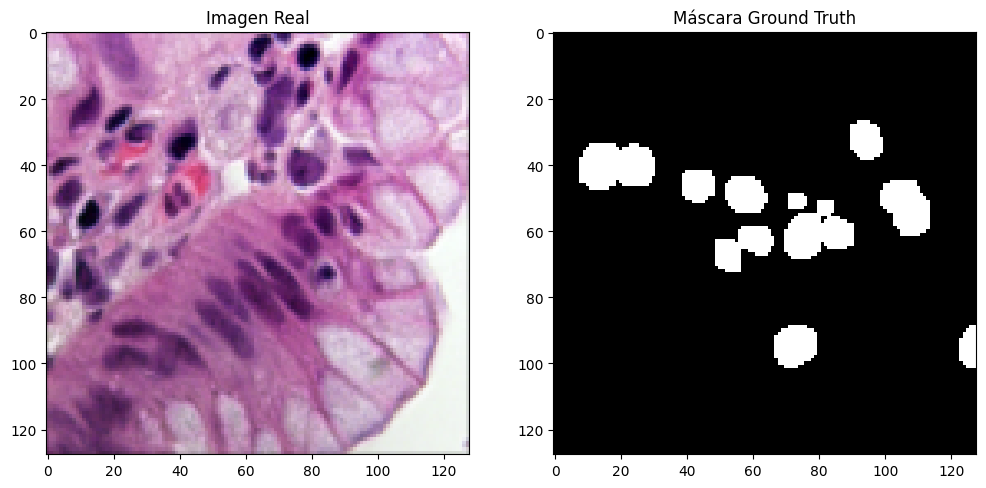

In [ ]:
# Mostramos la imagen y su máscara asociada
plt.figure(figsize=(12, 6))

# Imagen real
plt.subplot(1, 2, 1)
plt.imshow(X_test[5])
plt.title('Imagen Real')

# Máscara ground truth
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(y_train[5]), cmap='gray')
plt.title('Máscara Ground Truth')

plt.show()

# **PREPROCESSING IMAGES**

In [ ]:
def prepro_img(img):
  """We convert the images into gray scales,
     we invert the images with a white background
     to a black background, we normalize
     between 1 and 0 and statistics"""

  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  histr = cv2.calcHist([img_gray],[0],None,[256],[0,256])
  value_to_convert = np.argmax(histr)
  if value_to_convert >= 128 :
    img_gray = (255-img_gray)
  img = normalise_zero_one(img_gray)

  return img

def normalise_zero_one(image):
    """Image normalisation between 1 - 0"""

    image = image.astype(np.float32)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret

In [ ]:
X_train_pre = np.ones((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_pre = np.ones((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

for ind, x_img in enumerate(X_train[:]):
  x_g = prepro_img(x_img)
  X_train_pre[ind] = x_g


for ind, x_img in enumerate(X_test[:]):
  x_g = prepro_img(x_img)
  X_test_pre[ind] = x_g

X_vald_pre = X_train_pre[603:670,:,:]
X_train_pre = X_train_pre[0:603:,:]

y_train = y_train[:, :, :, 0]
y_vald = y_train[603:670:,:,:]
y_train = y_train[0:603:,:,:]

# **SEGMENTATION WITH GRAY SCALE**

In [ ]:
def otsu_segmentation(img):
  #In order to better select the treshold, "threshold_otsu" is used. https://github.com/j-manansala/thresholding/blob/main/Image%20Segmentation%20using%20Thresholding%20Methods.ipynb
  img = cv2.convertScaleAbs(img)
  (thresh, im) = cv2.threshold(img,0, 1, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
  return im

In [ ]:
def Kittler_illingwort_segmentation(img):

  img = (img * 255).astype(np.uint8)

  histogram = cv2.calcHist([img], [0], None, [256], [0, 256])
  histogram = histogram.ravel().astype(np.float32)
  histogram /= histogram.sum()
  bins = np.arange(256)
  variance = np.zeros(256)

  for t in range(1, 256):
    p1 = histogram[:t]
    p2 = histogram[t:]

    if p1.sum() == 0 or p2.sum() == 0:
        continue

    m1 = np.dot(bins[:t], p1) / p1.sum()
    m2 = np.dot(bins[t:], p2) / p2.sum()

    var1 = np.dot((bins[:t] - m1) ** 2, p1) / p1.sum()
    var2 = np.dot((bins[t:] - m2) ** 2, p2) / p2.sum()

    variance[t] = p1.sum() * var1 + p2.sum() * var2

  optimal_threshold = np.argmin(variance)
  thresh, im = cv2.threshold(img, optimal_threshold, 255,cv2.THRESH_BINARY)
  im = normalise_zero_one(im).astype(np.uint8)
  return im

# **U-Net**

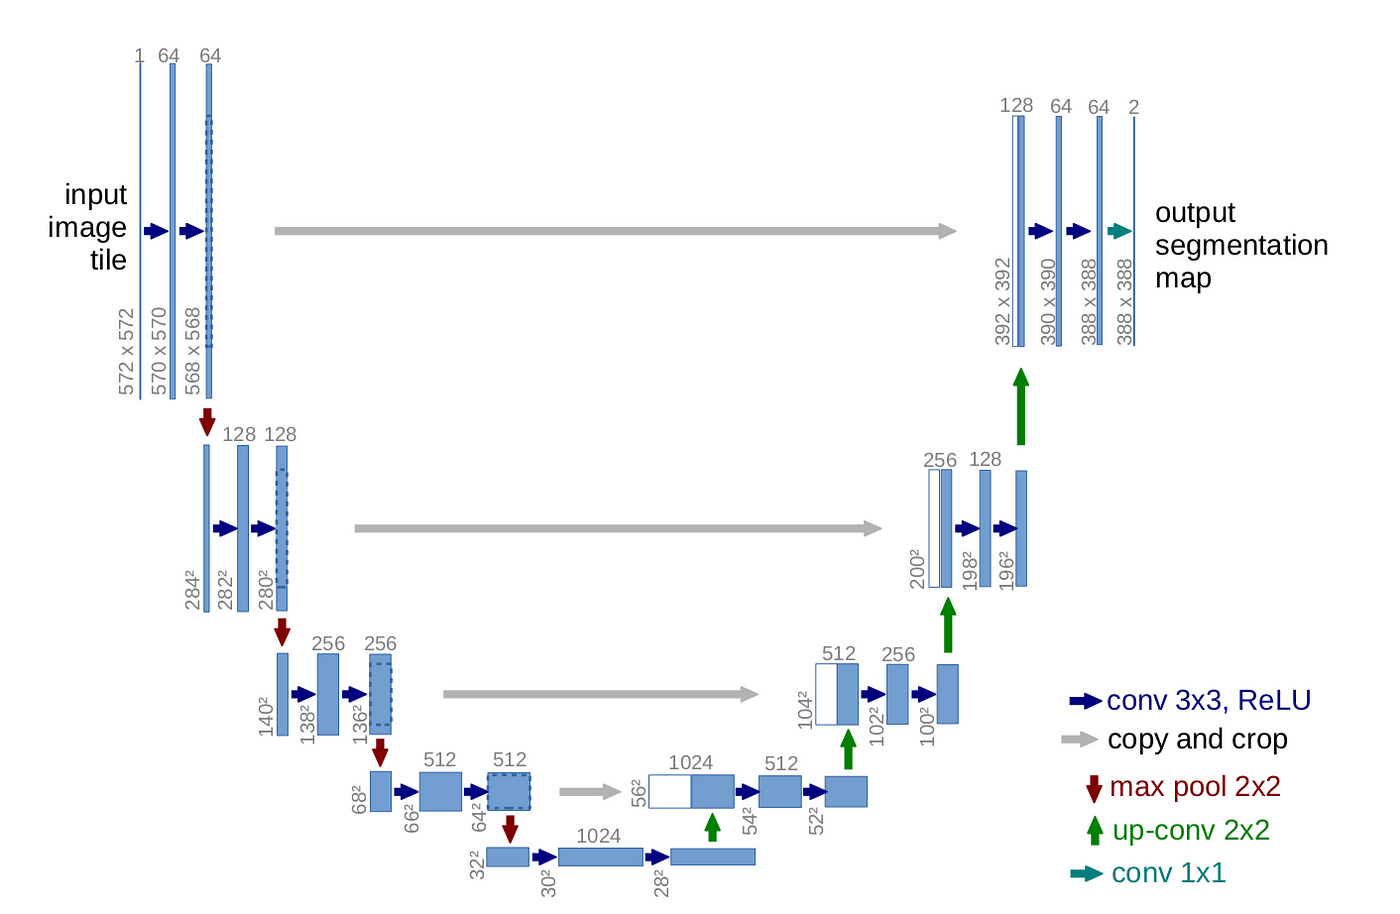

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/U_NET

import u

%load_ext tensorboard

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/U_NET
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Model: "U_Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 128, 128, 16)         160       ['input_4[0][0]']             
                                                                                                  
 dropout_27 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_57[0][0]']           
                                                                                                  
 batch_normalization_45 (Ba  (None, 128, 128, 16)         64        ['dropout_27[0][0]']          
 tchNormalization)                                                                            

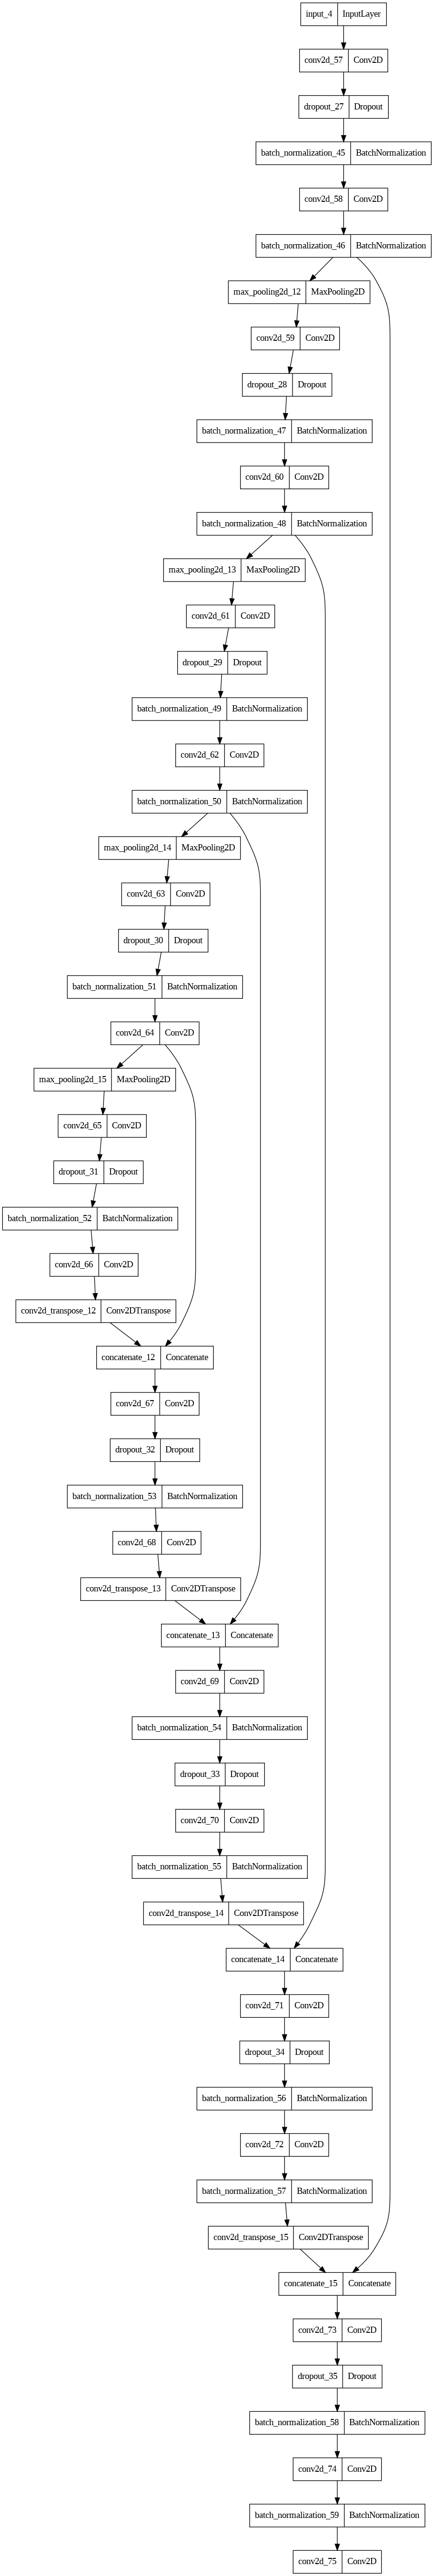

In [ ]:
unet_model = u.CreateModel(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1,summa=True)
plot_model(unet_model)

In [ ]:
#definition of metrics

def DICE_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice

IOU_metric = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0])

In [ ]:
unet_model.compile(optimizer= tf.keras.optimizers.experimental.RMSprop(),
                loss= tf.keras.losses.BinaryFocalCrossentropy(from_logits=True),
                metrics=['accuracy',IOU_metric,DICE_metric])

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS
!rm -r ./TRAIN/UNET/checkpoints/*
!rm -r ./TRAIN/UNET/logs/*
!rm -r ./TRAIN/UNET/csv/*
!touch "./TRAIN/UNET/csv/unet_train.csv"

path_checkpoint = './TRAIN/UNET/checkpoints'
path_tensorboard = './TRAIN/UNET/logs'
path_csv_train = './TRAIN/UNET/csv/unet_train.csv'



model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                               save_best_only= True,
                                                               monitor='accuracy')

tensorboard_callback = TensorBoard(log_dir = path_tensorboard , histogram_freq=1)

csv_callback = CSVLogger(path_csv_train)

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS


In [ ]:
EPOCHS = 300

history_unet = unet_model.fit(X_train_pre, y_train,
                              validation_data = (X_vald_pre, y_vald),
                              validation_freq=1,
                              epochs=EPOCHS,
                              callbacks=[model_checkpoint_callback,tensorboard_callback,csv_callback],
                              batch_size=2)

Epoch 1/300
302/302 [==============================] - 26s 59ms/step - loss: 0.1693 - accuracy: 0.9114 - io_u_1: 0.7652 - DICE_metric: 0.7519 - val_loss: 0.1530 - val_accuracy: 0.9166 - val_io_u_1: 0.7920 - val_DICE_metric: 0.7744
Epoch 2/300
302/302 [==============================] - 16s 52ms/step - loss: 0.1525 - accuracy: 0.9222 - io_u_1: 0.8012 - DICE_metric: 0.8238 - val_loss: 0.1500 - val_accuracy: 0.9391 - val_io_u_1: 0.8317 - val_DICE_metric: 0.8432
Epoch 3/300
302/302 [==============================] - 7s 24ms/step - loss: 0.1513 - accuracy: 0.9218 - io_u_1: 0.7998 - DICE_metric: 0.8320 - val_loss: 0.1478 - val_accuracy: 0.9519 - val_io_u_1: 0.8370 - val_DICE_metric: 0.8852
Epoch 4/300
302/302 [==============================] - 15s 51ms/step - loss: 0.1499 - accuracy: 0.9297 - io_u_1: 0.7944 - DICE_metric: 0.8505 - val_loss: 0.1991 - val_accuracy: 0.9033 - val_io_u_1: 0.8004 - val_DICE_metric: 0.5308
Epoch 5/300
302/302 [==============================] - 15s 51ms/step - loss: 

# **MF2-Net**

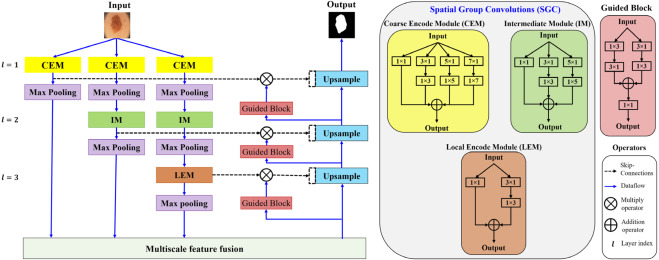

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/MF2_NET

import mf2
from tensorflow.keras.utils import plot_model
from importlib import reload
reload(mf2)
#%load_ext tensorboard

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/MF2_NET


<module 'mf2' from '/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/MF2_NET/mf2.py'>

Model: "MF2_Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 128, 128, 32)         128       ['input_1[0][0]']             
                                                                                                  
 conv2d_17 (Conv2D)          (None, 128, 128, 32)         192       ['input_1[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 32)         256       ['input_1[0][0]']             
                                                                                            

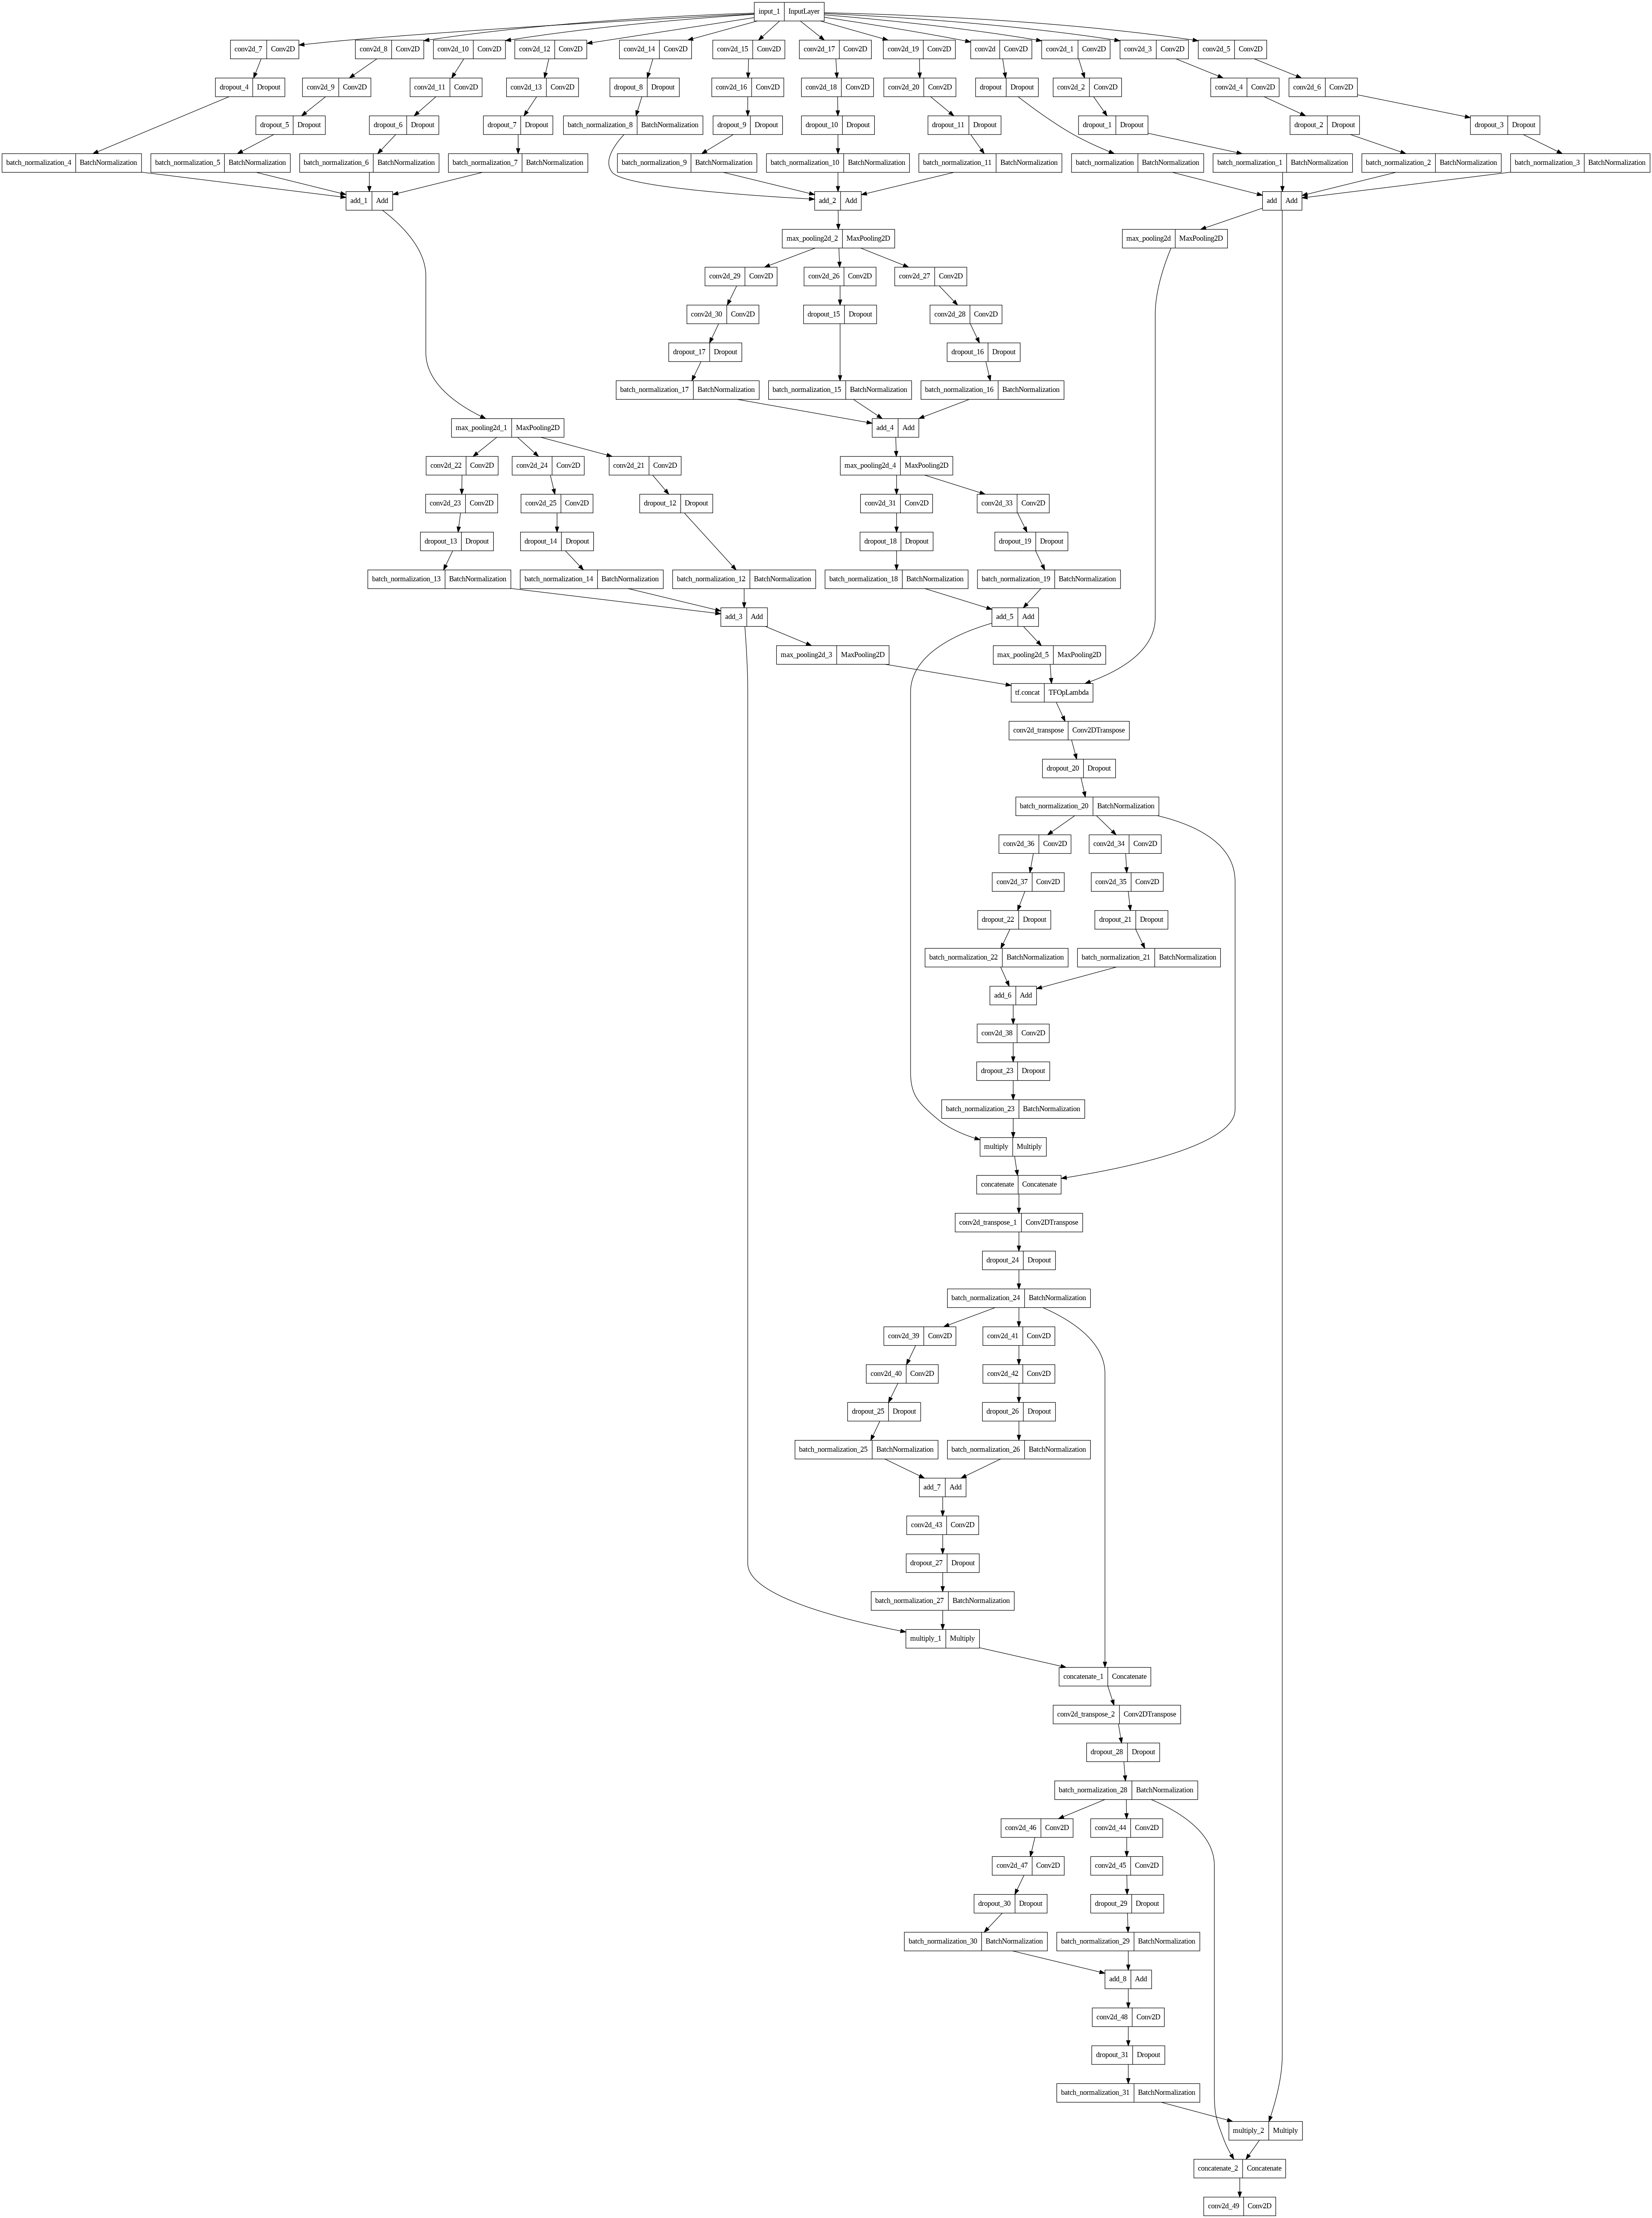

In [ ]:
mf2_model = mf2.CreateModel(K=[1,3,5,7],IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1,type_op_decoder_block ='convtranspose',summa=True)
plot_model(mf2_model)

In [ ]:
#definition of metrics

def DICE_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice

IOU_metric = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0])

In [ ]:
mf2_model.compile(optimizer= tf.keras.optimizers.experimental.RMSprop(),
                loss= tf.keras.losses.BinaryFocalCrossentropy(from_logits=True),
                metrics=['accuracy',IOU_metric,DICE_metric])

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS
!rm -r ./TRAIN/MF2/checkpoints/*
!rm -r ./TRAIN/MF2/logs/*
!rm -r ./TRAIN/MF2/csv/*
!touch "./TRAIN/MF2/csv/unet_train.csv"

path_checkpoint = './TRAIN/MF2/checkpoints'
path_tensorboard = './TRAIN/MF2/logs'
path_csv_train = './TRAIN/MF2/csv/mf2_train.csv'


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoint,monitor='accuracy')

tensorboard_callback = TensorBoard(log_dir = path_tensorboard , histogram_freq=1)

csv_callback = CSVLogger(path_csv_train)

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS


In [ ]:
EPOCHS = 300

history_mf2 = mf2_model.fit(X_train_pre, y_train,
                              validation_data = (X_vald_pre, y_vald),
                              validation_freq=1,
                              epochs=EPOCHS,
                              callbacks=[model_checkpoint_callback,tensorboard_callback,csv_callback],
                              batch_size=2)

Epoch 1/300
302/302 [==============================] - 73s 139ms/step - loss: 0.1826 - accuracy: 0.8011 - io_u: 0.7499 - DICE_metric: 0.3927 - val_loss: 0.1607 - val_accuracy: 0.8655 - val_io_u: 0.7753 - val_DICE_metric: 0.6027
Epoch 2/300
302/302 [==============================] - 37s 122ms/step - loss: 0.1554 - accuracy: 0.8923 - io_u: 0.7594 - DICE_metric: 0.7259 - val_loss: 0.1540 - val_accuracy: 0.9325 - val_io_u: 0.7902 - val_DICE_metric: 0.8219
Epoch 3/300
302/302 [==============================] - 36s 119ms/step - loss: 0.1530 - accuracy: 0.9104 - io_u: 0.7694 - DICE_metric: 0.7948 - val_loss: 0.1515 - val_accuracy: 0.9252 - val_io_u: 0.7868 - val_DICE_metric: 0.8066
Epoch 4/300
302/302 [==============================] - 37s 122ms/step - loss: 0.1518 - accuracy: 0.9182 - io_u: 0.7730 - DICE_metric: 0.8177 - val_loss: 0.1497 - val_accuracy: 0.9437 - val_io_u: 0.7916 - val_DICE_metric: 0.8570
Epoch 5/300
302/302 [==============================] - 38s 125ms/step - loss: 0.1509 - a

# **MultiResUNet**

In [ ]:
https://www.sciencedirect.com/science/article/pii/S0893608019302503?via%3Dihub

In [ ]:
https://github.com/nibtehaz/MultiResUNet/tree/master

SyntaxError: ignored

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')

    model = Model(inputs=[inputs], outputs=[conv10])

    return model





model_MultiResUnet = MultiResUnet(128, 128,3)
#print(model_MultiResUnet.summary())



[Dimension(None), Dimension(128), Dimension(128), Dimension(26)]
None
[Dimension(None), Dimension(128), Dimension(128), Dimension(17)]
None
[Dimension(None), Dimension(128), Dimension(128), Dimension(8)]
None
--------------------------------------------------------------------------
[Dimension(None), Dimension(64), Dimension(64), Dimension(53)]
None
[Dimension(None), Dimension(64), Dimension(64), Dimension(35)]
None
[Dimension(None), Dimension(64), Dimension(64), Dimension(17)]
None
--------------------------------------------------------------------------
[Dimension(None), Dimension(32), Dimension(32), Dimension(106)]
None
[Dimension(None), Dimension(32), Dimension(32), Dimension(71)]
None
[Dimension(None), Dimension(32), Dimension(32), Dimension(35)]
None
--------------------------------------------------------------------------
[Dimension(None), Dimension(16), Dimension(16), Dimension(213)]
None
[Dimension(None), Dimension(16), Dimension(16), Dimension(142)]
None
[Dimension(None), D

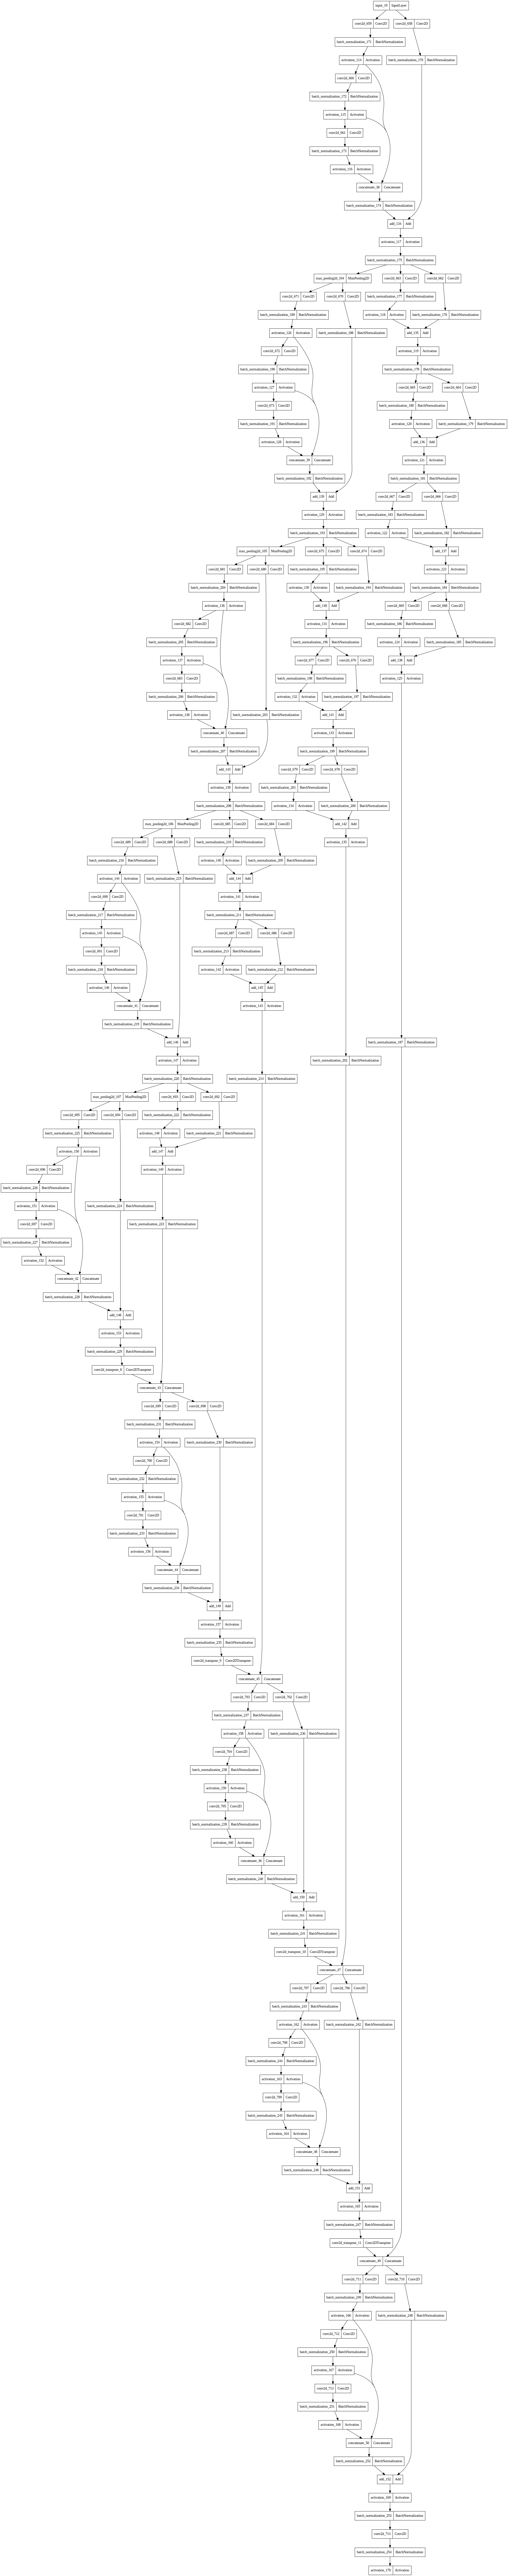

In [ ]:
plot_model(model_MultiResUnet)

# **SWIN UNET**

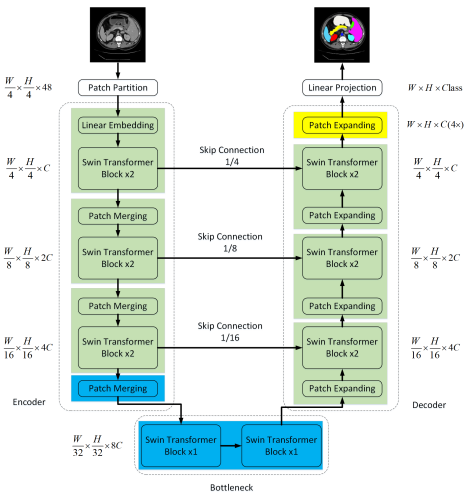

In [ ]:
%cd '/content/drive/MyDrive/DOCTORADO/MATERIAS/SEMESTRE_2/DEEP_LEARNING/TAREA_4/MODELS/SWIN_UNET'
url_before = '/content/drive/MyDrive/DOCTORADO/MATERIAS/SEMESTRE_2/DEEP_LEARNING/TAREA_4'
url_now = '/MODELS/SWIN_UNET/train' #never challange
path = url_before + url_now

import swin
from tensorflow.keras.utils import plot_model
from importlib import reload
reload(swin)
%load_ext tensorboard

/content/drive/MyDrive/DOCTORADO/MATERIAS/SEMESTRE_2/DEEP_LEARNING/TAREA_4/MODELS/SWIN_UNET
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
num_heads=[4, 8, 16, 16]
window_size =[4, 2, 2, 2]

In [ ]:
2 // 4[8, 16, 32, 32]

0

In [ ]:
swin.CreateModel(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=3, filter_num_begin=6, n_labels=2, depth=4, stack_num_down=128, stack_num_up=128,patch_size=(4,4), num_heads=[4, 4, 8, 8], window_size =[4, 2, 2, 2], num_mlp=150, summa= True)


ValueError: ignored

# **SAM**

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/SAM
!pip install -r requirements.txt

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/SAM
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-t65ozb62
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-t65ozb62
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-h26r_x3c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-h26r_x3c
  Resolved https://github.com/huggingface/transformers.git to commit e2647450511e44ad9020d7d5dd455b2851850538
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/SAM
import sam
from importlib import reload
reload(sam)

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/SAM


<module 'sam' from '/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/SAM/sam.py'>

In [ ]:
# %cd /content/drive/MyDrive/TAREA_4/MODELS
# !rm -r ./TRAIN/SAM/weigths/*
# !rm -r ./TRAIN/SAM/logs/*
# !rm -r ./TRAIN/SAM/csv/*
# !touch "./TRAIN/SAM/csv/sam_train.csv"


In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS

path_weigths = './TRAIN/SAM/weigths/vit_DSB.pth'
path_tensorboard = './TRAIN/SAM/logs/'
path_csv_train = './TRAIN/SAM/csv/sam_train.csv'


/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS


In [ ]:
train_dataloader,dataset,processor,train_dataset = sam.datasetToSAM(X_train_pre,y_train)
val_dataloader,val_dataset,val_processor,val_dataset = sam.datasetToSAM(X_vald_pre,y_vald)
#view new weigths is upload
model, optimizer, seg_loss = sam.ParameterFineTunningSam(plot_model=False)

In [ ]:
sam.SamTrain(num_epochs=[42,299],
         model=model,
         train_dataloader=train_dataloader,
         seg_loss=seg_loss,optimizer=optimizer,
         val_dataloader=val_dataloader,
         csv_filename = path_csv_train,
         ts_log = path_tensorboard,
         path_save_weights= path_weigths)

100%|██████████| 302/302 [05:13<00:00,  1.04s/it]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |42   |0.134969|0.748328|0.749250|0.000960
-------+-----+--------+--------+--------+--------
Valid  |42   |0.125097|0.774834|0.774834|0.000135
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.00s/it]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |43   |0.134260|0.749223|0.749250|0.000603
-------+-----+--------+--------+--------+--------
Valid  |43   |0.126015|0.774834|0.774834|0.000010
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |44   |0.133797|0.749237|0.749250|0.000805
-------+-----+--------+--------+--------+--------
Valid  |44   |0.124204|0.774834|0.774834|0.000027
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7738037


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |45   |0.133734|0.749175|0.749250|0.000429
-------+-----+--------+--------+--------+--------
Valid  |45   |0.127974|0.773804|0.774834|0.001142
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.7748304


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |46   |0.134117|0.749015|0.749250|0.001029
-------+-----+--------+--------+--------+--------
Valid  |46   |0.126830|0.774830|0.774834|0.000043
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |47   |0.133579|0.749206|0.749250|0.000255
-------+-----+--------+--------+--------+--------
Valid  |47   |0.125989|0.774834|0.774834|0.000014
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7723917


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |48   |0.134339|0.749236|0.749250|0.000478
-------+-----+--------+--------+--------+--------
Valid  |48   |0.124894|0.772392|0.774834|0.003346
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7742911


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |49   |0.133556|0.748902|0.749250|0.000463
-------+-----+--------+--------+--------+--------
Valid  |49   |0.127805|0.774291|0.774835|0.003274
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |50   |0.134243|0.748854|0.749250|0.001034
-------+-----+--------+--------+--------+--------
Valid  |50   |0.126866|0.774834|0.774834|0.000032
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7747056


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |51   |0.134201|0.748996|0.749250|0.000464
-------+-----+--------+--------+--------+--------
Valid  |51   |0.125876|0.774706|0.774834|0.000706
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |52   |0.134268|0.748949|0.749250|0.001199
-------+-----+--------+--------+--------+--------
Valid  |52   |0.126057|0.774834|0.774834|0.000105
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:02<00:00,  1.00s/it]


val_accura 0.7747885


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |53   |0.133217|0.749043|0.749250|0.000862
-------+-----+--------+--------+--------+--------
Valid  |53   |0.125413|0.774788|0.774834|0.000172
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77362245


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |54   |0.134037|0.749160|0.749250|0.000552
-------+-----+--------+--------+--------+--------
Valid  |54   |0.125113|0.773622|0.774834|0.002184
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77428746


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |55   |0.134118|0.748892|0.749250|0.001080
-------+-----+--------+--------+--------+--------
Valid  |55   |0.125114|0.774287|0.774834|0.000546
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77464634


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |56   |0.133774|0.748802|0.749250|0.002652
-------+-----+--------+--------+--------+--------
Valid  |56   |0.129305|0.774646|0.774834|0.000333
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7734375


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |57   |0.134014|0.749103|0.749250|0.000541
-------+-----+--------+--------+--------+--------
Valid  |57   |0.124519|0.773438|0.774835|0.006905
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.00s/it]


val_accura 0.7748049


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |58   |0.133630|0.748913|0.749250|0.000633
-------+-----+--------+--------+--------+--------
Valid  |58   |0.123830|0.774805|0.774834|0.000558
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7737044


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |59   |0.132949|0.749117|0.749250|0.000805
-------+-----+--------+--------+--------+--------
Valid  |59   |0.124731|0.773704|0.774835|0.006370
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.7747885


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |60   |0.132916|0.749131|0.749250|0.000649
-------+-----+--------+--------+--------+--------
Valid  |60   |0.125915|0.774788|0.774835|0.000245
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.00s/it]


val_accura 0.7741918


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |61   |0.133704|0.748915|0.749250|0.001623
-------+-----+--------+--------+--------+--------
Valid  |61   |0.125915|0.774192|0.774834|0.001658
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77380097


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |62   |0.134100|0.749084|0.749250|0.000592
-------+-----+--------+--------+--------+--------
Valid  |62   |0.128035|0.773801|0.774834|0.001495
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77473927


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |63   |0.133690|0.748849|0.749250|0.001730
-------+-----+--------+--------+--------+--------
Valid  |63   |0.129578|0.774739|0.774836|0.001940
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.00s/it]


val_accura 0.7728499


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |64   |0.133974|0.749081|0.749250|0.001334
-------+-----+--------+--------+--------+--------
Valid  |64   |0.125118|0.772850|0.774837|0.005524
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7743184


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |65   |0.133352|0.748821|0.749251|0.002529
-------+-----+--------+--------+--------+--------
Valid  |65   |0.127710|0.774318|0.774834|0.000789
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:02<00:00,  1.00s/it]


val_accura 0.771662


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |66   |0.133720|0.748990|0.749250|0.001346
-------+-----+--------+--------+--------+--------
Valid  |66   |0.125531|0.771662|0.774836|0.009710
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.00s/it]


val_accura 0.77460265


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |67   |0.133812|0.748791|0.749250|0.001615
-------+-----+--------+--------+--------+--------
Valid  |67   |0.125938|0.774603|0.774834|0.000381
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.77426285


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |68   |0.133887|0.749113|0.749250|0.001138
-------+-----+--------+--------+--------+--------
Valid  |68   |0.125364|0.774263|0.774834|0.000795
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.7742446


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |69   |0.132921|0.748879|0.749250|0.001879
-------+-----+--------+--------+--------+--------
Valid  |69   |0.125165|0.774245|0.774834|0.000998
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.7745097


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |70   |0.133859|0.748874|0.749250|0.001532
-------+-----+--------+--------+--------+--------
Valid  |70   |0.125366|0.774510|0.774834|0.000232
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.77434754


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |71   |0.132841|0.749010|0.749252|0.001746
-------+-----+--------+--------+--------+--------
Valid  |71   |0.125940|0.774348|0.774834|0.000270
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.7732061


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |72   |0.132681|0.749071|0.749250|0.000626
-------+-----+--------+--------+--------+--------
Valid  |72   |0.127506|0.773206|0.774837|0.008603
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:03<00:00,  1.01s/it]


val_accura 0.7732052


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |73   |0.133822|0.748989|0.749250|0.001287
-------+-----+--------+--------+--------+--------
Valid  |73   |0.126231|0.773205|0.774834|0.004525
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.77432203


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |74   |0.132583|0.749082|0.749250|0.001534
-------+-----+--------+--------+--------+--------
Valid  |74   |0.126806|0.774322|0.774834|0.000774
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [05:05<00:00,  1.01s/it]


val_accura 0.7746245


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |75   |0.133485|0.748504|0.749250|0.001910
-------+-----+--------+--------+--------+--------
Valid  |75   |0.126215|0.774625|0.774834|0.000784
-------+-----+--------+--------+--------+--------
None




 35%|███▍      | 105/302 [01:46<03:23,  1.03s/it]

In [ ]:
sam.SamTrain(num_epochs=[76,299],
         model=model,
         train_dataloader=train_dataloader,
         seg_loss=seg_loss,optimizer=optimizer,
         val_dataloader=val_dataloader,
         csv_filename = path_csv_train,
         ts_log = path_tensorboard,
         path_save_weights= path_weigths)

100%|██████████| 302/302 [04:50<00:00,  1.04it/s]


val_accura 0.7741836


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |76   |0.134589|0.749238|0.749250|0.000591
-------+-----+--------+--------+--------+--------
Valid  |76   |0.128034|0.774184|0.774834|0.000146
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:42<00:00,  1.07it/s]


val_accura 0.7748049


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |77   |0.134140|0.749036|0.749250|0.003356
-------+-----+--------+--------+--------+--------
Valid  |77   |0.126378|0.774805|0.774834|0.000150
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.77265954


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |78   |0.134357|0.749211|0.749250|0.001167
-------+-----+--------+--------+--------+--------
Valid  |78   |0.124804|0.772660|0.774834|0.004030
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.77470833


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |79   |0.134311|0.749193|0.749250|0.000964
-------+-----+--------+--------+--------+--------
Valid  |79   |0.127597|0.774708|0.774834|0.000078
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:47<00:00,  1.05it/s]


val_accura 0.7738693


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |80   |0.133680|0.749066|0.749250|0.000910
-------+-----+--------+--------+--------+--------
Valid  |80   |0.124944|0.773869|0.774834|0.000762
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.7740023


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |81   |0.134303|0.749178|0.749250|0.000515
-------+-----+--------+--------+--------+--------
Valid  |81   |0.126754|0.774002|0.774834|0.001676
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:43<00:00,  1.06it/s]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |82   |0.134127|0.748750|0.749250|0.000617
-------+-----+--------+--------+--------+--------
Valid  |82   |0.126301|0.774834|0.774834|0.000051
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:43<00:00,  1.06it/s]


val_accura 0.77305853


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |83   |0.134327|0.749040|0.749250|0.000831
-------+-----+--------+--------+--------+--------
Valid  |83   |0.126149|0.773059|0.774834|0.001353
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:43<00:00,  1.06it/s]


val_accura 0.77482855


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |84   |0.133544|0.748926|0.749250|0.001371
-------+-----+--------+--------+--------+--------
Valid  |84   |0.125427|0.774829|0.774834|0.000077
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:43<00:00,  1.06it/s]


val_accura 0.77386475


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |85   |0.133538|0.749024|0.749250|0.000575
-------+-----+--------+--------+--------+--------
Valid  |85   |0.126133|0.773865|0.774834|0.001716
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:43<00:00,  1.06it/s]


val_accura 0.77401596


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |86   |0.133407|0.749004|0.749250|0.002529
-------+-----+--------+--------+--------+--------
Valid  |86   |0.127627|0.774016|0.774834|0.001378
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.7747666


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |87   |0.133900|0.748991|0.749250|0.000392
-------+-----+--------+--------+--------+--------
Valid  |87   |0.126919|0.774767|0.774834|0.000350
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.77396953


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |88   |0.133869|0.748957|0.749250|0.001068
-------+-----+--------+--------+--------+--------
Valid  |88   |0.126927|0.773970|0.774834|0.000884
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.7741198


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |89   |0.133375|0.748963|0.749250|0.000532
-------+-----+--------+--------+--------+--------
Valid  |89   |0.123741|0.774120|0.774834|0.001465
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.77482766


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |90   |0.133308|0.748986|0.749250|0.000915
-------+-----+--------+--------+--------+--------
Valid  |90   |0.125623|0.774828|0.774834|0.000034
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.7745799


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |91   |0.133474|0.749187|0.749250|0.000714
-------+-----+--------+--------+--------+--------
Valid  |91   |0.125489|0.774580|0.774834|0.000168
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.77251285


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |92   |0.133325|0.749166|0.749250|0.001228
-------+-----+--------+--------+--------+--------
Valid  |92   |0.127036|0.772513|0.774834|0.007081
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.7741125


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |93   |0.133957|0.748690|0.749250|0.001655
-------+-----+--------+--------+--------+--------
Valid  |93   |0.123938|0.774113|0.774834|0.000864
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.7747839


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |94   |0.133993|0.749018|0.749250|0.001301
-------+-----+--------+--------+--------+--------
Valid  |94   |0.125737|0.774784|0.774834|0.000083
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.774527


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |95   |0.133407|0.749010|0.749250|0.001358
-------+-----+--------+--------+--------+--------
Valid  |95   |0.126633|0.774527|0.774834|0.000244
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:43<00:00,  1.06it/s]


val_accura 0.7746017


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |96   |0.133837|0.748817|0.749250|0.001809
-------+-----+--------+--------+--------+--------
Valid  |96   |0.125206|0.774602|0.774834|0.000153
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:43<00:00,  1.07it/s]


val_accura 0.7747839


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |97   |0.134431|0.749078|0.749250|0.000991
-------+-----+--------+--------+--------+--------
Valid  |97   |0.128792|0.774784|0.774834|0.000239
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.77263767


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |98   |0.134354|0.748782|0.749250|0.001469
-------+-----+--------+--------+--------+--------
Valid  |98   |0.125147|0.772638|0.774836|0.006790
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.77433574


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |99   |0.133366|0.749105|0.749250|0.001459
-------+-----+--------+--------+--------+--------
Valid  |99   |0.125213|0.774336|0.774834|0.000379
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.7743867


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |100  |0.133718|0.748936|0.749250|0.002223
-------+-----+--------+--------+--------+--------
Valid  |100  |0.127341|0.774387|0.774834|0.000788
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.77258754


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |101  |0.133058|0.748882|0.749250|0.002428
-------+-----+--------+--------+--------+--------
Valid  |101  |0.126104|0.772588|0.774179|0.005701
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |102  |0.132954|0.748940|0.749248|0.002961
-------+-----+--------+--------+--------+--------
Valid  |102  |0.124322|0.774834|0.774834|0.000084
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.774609


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |103  |0.133462|0.749031|0.749250|0.000805
-------+-----+--------+--------+--------+--------
Valid  |103  |0.125032|0.774609|0.774834|0.001395
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.7720182


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |104  |0.133784|0.749010|0.749250|0.001119
-------+-----+--------+--------+--------+--------
Valid  |104  |0.124769|0.772018|0.774834|0.005437
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.7745343


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |105  |0.133300|0.748994|0.749250|0.002037
-------+-----+--------+--------+--------+--------
Valid  |105  |0.127783|0.774534|0.774834|0.001586
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.7733218


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |106  |0.133652|0.748864|0.749250|0.001914
-------+-----+--------+--------+--------+--------
Valid  |106  |0.125914|0.773322|0.774834|0.006226
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:46<00:00,  1.05it/s]


val_accura 0.7715782


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |107  |0.133001|0.748878|0.749250|0.002298
-------+-----+--------+--------+--------+--------
Valid  |107  |0.126043|0.771578|0.774836|0.008678
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:46<00:00,  1.05it/s]


val_accura 0.774108


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |108  |0.133305|0.748688|0.749250|0.003145
-------+-----+--------+--------+--------+--------
Valid  |108  |0.126734|0.774108|0.774835|0.002545
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:46<00:00,  1.05it/s]


val_accura 0.77398866


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |109  |0.133527|0.748988|0.749250|0.002102
-------+-----+--------+--------+--------+--------
Valid  |109  |0.128103|0.773989|0.774835|0.003075
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:47<00:00,  1.05it/s]


val_accura 0.7743949


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |110  |0.134297|0.748952|0.749250|0.002220
-------+-----+--------+--------+--------+--------
Valid  |110  |0.125653|0.774395|0.774834|0.002302
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.7738948


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |111  |0.133443|0.748960|0.749253|0.002529
-------+-----+--------+--------+--------+--------
Valid  |111  |0.129341|0.773895|0.774835|0.005431
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:44<00:00,  1.06it/s]


val_accura 0.7743849


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |112  |0.133470|0.749191|0.749309|0.003022
-------+-----+--------+--------+--------+--------
Valid  |112  |0.126194|0.774385|0.774834|0.000945
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:46<00:00,  1.06it/s]


val_accura 0.7733482


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |113  |0.134547|0.749005|0.749250|0.002208
-------+-----+--------+--------+--------+--------
Valid  |113  |0.125841|0.773348|0.774834|0.001947
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:45<00:00,  1.06it/s]


val_accura 0.77384377


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |114  |0.133519|0.748932|0.749250|0.002045
-------+-----+--------+--------+--------+--------
Valid  |114  |0.126807|0.773844|0.774834|0.004151
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:47<00:00,  1.05it/s]


val_accura 0.7747648


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |115  |0.133017|0.748779|0.749250|0.001700
-------+-----+--------+--------+--------+--------
Valid  |115  |0.128660|0.774765|0.774834|0.000340
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:49<00:00,  1.04it/s]


val_accura 0.77173764


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |116  |0.133443|0.749115|0.749250|0.002202
-------+-----+--------+--------+--------+--------
Valid  |116  |0.127316|0.771738|0.774835|0.008954
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:48<00:00,  1.05it/s]


val_accura 0.7729756


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |117  |0.133644|0.748758|0.749251|0.003734
-------+-----+--------+--------+--------+--------
Valid  |117  |0.125766|0.772976|0.774835|0.006532
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:47<00:00,  1.05it/s]


In [ ]:
sam.SamTrain(num_epochs=[118,299],
         model=model,
         train_dataloader=train_dataloader,
         seg_loss=seg_loss,optimizer=optimizer,
         val_dataloader=val_dataloader,
         csv_filename = path_csv_train,
         ts_log = path_tensorboard,
         path_save_weights= path_weigths)

100%|██████████| 302/302 [05:04<00:00,  1.01s/it]


val_accura 0.774128


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |118  |0.134756|0.748434|0.749249|0.001586
-------+-----+--------+--------+--------+--------
Valid  |118  |0.128008|0.774128|0.774834|0.000603
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:54<00:00,  1.02it/s]


val_accura 0.7743858


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |119  |0.133961|0.749127|0.749250|0.001098
-------+-----+--------+--------+--------+--------
Valid  |119  |0.125762|0.774386|0.774834|0.000198
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:57<00:00,  1.01it/s]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |120  |0.133778|0.749204|0.749250|0.000809
-------+-----+--------+--------+--------+--------
Valid  |120  |0.125338|0.774834|0.774834|0.000006
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:57<00:00,  1.02it/s]


val_accura 0.7746792


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |121  |0.133386|0.749145|0.749251|0.002057
-------+-----+--------+--------+--------+--------
Valid  |121  |0.124512|0.774679|0.774834|0.000336
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77103436


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |122  |0.134725|0.749095|0.749250|0.002337
-------+-----+--------+--------+--------+--------
Valid  |122  |0.126697|0.771034|0.774837|0.009297
-------+-----+--------+--------+--------+--------
None




 75%|███████▌  | 227/302 [03:42<01:14,  1.00it/s]

In [ ]:
sam.SamTrain(num_epochs=[123,299],
         model=model,
         train_dataloader=train_dataloader,
         seg_loss=seg_loss,optimizer=optimizer,
         val_dataloader=val_dataloader,
         csv_filename = path_csv_train,
         ts_log = path_tensorboard,
         path_save_weights= path_weigths)

100%|██████████| 302/302 [05:01<00:00,  1.00it/s]


val_accura 0.7747794


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |123  |0.134481|0.749076|0.749250|0.001499
-------+-----+--------+--------+--------+--------
Valid  |123  |0.127842|0.774779|0.774834|0.000143
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:57<00:00,  1.02it/s]


val_accura 0.77478665


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |124  |0.134213|0.748996|0.749250|0.001007
-------+-----+--------+--------+--------+--------
Valid  |124  |0.124419|0.774787|0.774834|0.000115
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.774537


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |125  |0.134023|0.749133|0.749250|0.000701
-------+-----+--------+--------+--------+--------
Valid  |125  |0.126275|0.774537|0.774834|0.000266
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:54<00:00,  1.02it/s]


val_accura 0.77480125


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |126  |0.133950|0.749186|0.749250|0.001069
-------+-----+--------+--------+--------+--------
Valid  |126  |0.126605|0.774801|0.774834|0.000212
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:54<00:00,  1.02it/s]


val_accura 0.7745525


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |127  |0.133650|0.749146|0.749250|0.000570
-------+-----+--------+--------+--------+--------
Valid  |127  |0.126082|0.774553|0.774836|0.001492
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |128  |0.133272|0.749132|0.749250|0.001046
-------+-----+--------+--------+--------+--------
Valid  |128  |0.125997|0.774834|0.774834|0.000088
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |129  |0.134117|0.748961|0.749250|0.001348
-------+-----+--------+--------+--------+--------
Valid  |129  |0.126530|0.774834|0.774834|0.000132
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7739085


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |130  |0.133585|0.749052|0.749250|0.001129
-------+-----+--------+--------+--------+--------
Valid  |130  |0.125088|0.773908|0.774835|0.001542
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77408886


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |131  |0.133353|0.749082|0.749250|0.001721
-------+-----+--------+--------+--------+--------
Valid  |131  |0.127657|0.774089|0.774834|0.001764
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:57<00:00,  1.02it/s]


val_accura 0.7739841


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |132  |0.133789|0.748827|0.749250|0.001199
-------+-----+--------+--------+--------+--------
Valid  |132  |0.126960|0.773984|0.774834|0.001410
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7731342


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |133  |0.133687|0.749179|0.749250|0.001153
-------+-----+--------+--------+--------+--------
Valid  |133  |0.126666|0.773134|0.774835|0.006497
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7742328


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |134  |0.133469|0.749026|0.749251|0.001215
-------+-----+--------+--------+--------+--------
Valid  |134  |0.124157|0.774233|0.774834|0.000933
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:57<00:00,  1.02it/s]


val_accura 0.7744796


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |135  |0.133175|0.748933|0.749250|0.001152
-------+-----+--------+--------+--------+--------
Valid  |135  |0.126695|0.774480|0.774834|0.000313
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:57<00:00,  1.01it/s]


val_accura 0.77428013


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |136  |0.134059|0.748849|0.749250|0.002170
-------+-----+--------+--------+--------+--------
Valid  |136  |0.126281|0.774280|0.774834|0.002266
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:57<00:00,  1.02it/s]


val_accura 0.7746118


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |137  |0.132674|0.749072|0.749250|0.001319
-------+-----+--------+--------+--------+--------
Valid  |137  |0.128868|0.774612|0.774834|0.000354
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77449876


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |138  |0.133755|0.748986|0.749250|0.001736
-------+-----+--------+--------+--------+--------
Valid  |138  |0.126028|0.774499|0.774834|0.000214
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7735368


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |139  |0.133756|0.748947|0.749250|0.001290
-------+-----+--------+--------+--------+--------
Valid  |139  |0.127444|0.773537|0.774834|0.002451
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77100796


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |140  |0.133601|0.749124|0.749250|0.001164
-------+-----+--------+--------+--------+--------
Valid  |140  |0.127614|0.771008|0.774835|0.008385
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77449876


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |141  |0.134270|0.748909|0.749250|0.001844
-------+-----+--------+--------+--------+--------
Valid  |141  |0.124401|0.774499|0.774834|0.001395
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7738866


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |142  |0.132871|0.749199|0.749250|0.000547
-------+-----+--------+--------+--------+--------
Valid  |142  |0.126228|0.773887|0.775105|0.013517
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77456254


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |143  |0.134123|0.748996|0.749252|0.002629
-------+-----+--------+--------+--------+--------
Valid  |143  |0.128781|0.774563|0.774834|0.000249
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:58<00:00,  1.01it/s]


val_accura 0.77478755


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |144  |0.133857|0.749048|0.749228|0.001849
-------+-----+--------+--------+--------+--------
Valid  |144  |0.125026|0.774788|0.774835|0.001498
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.77465


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |145  |0.133078|0.749197|0.749250|0.000623
-------+-----+--------+--------+--------+--------
Valid  |145  |0.124800|0.774650|0.774835|0.002638
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |146  |0.133440|0.748809|0.749250|0.001519
-------+-----+--------+--------+--------+--------
Valid  |146  |0.125043|0.774834|0.774834|0.000215
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.77361333


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |147  |0.132924|0.748812|0.749250|0.001759
-------+-----+--------+--------+--------+--------
Valid  |147  |0.127413|0.773613|0.774834|0.003282
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.77397406


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |148  |0.133148|0.748908|0.749250|0.001674
-------+-----+--------+--------+--------+--------
Valid  |148  |0.125734|0.773974|0.774835|0.003241
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7746382


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |149  |0.134145|0.748870|0.749250|0.001542
-------+-----+--------+--------+--------+--------
Valid  |149  |0.125517|0.774638|0.774834|0.002654
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7747001


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |150  |0.133698|0.748898|0.749250|0.001949
-------+-----+--------+--------+--------+--------
Valid  |150  |0.125050|0.774700|0.774834|0.000211
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7742346


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |151  |0.133529|0.748930|0.749250|0.001959
-------+-----+--------+--------+--------+--------
Valid  |151  |0.124641|0.774235|0.774834|0.003128
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7741125


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |152  |0.133785|0.749040|0.749247|0.001255
-------+-----+--------+--------+--------+--------
Valid  |152  |0.128390|0.774113|0.774834|0.002402
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.77483404


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |153  |0.133029|0.749067|0.749250|0.001527
-------+-----+--------+--------+--------+--------
Valid  |153  |0.127417|0.774834|0.774834|0.000112
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7747065


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |154  |0.133182|0.748997|0.749251|0.002585
-------+-----+--------+--------+--------+--------
Valid  |154  |0.126367|0.774706|0.774834|0.001166
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.77359873


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |155  |0.133413|0.749008|0.749250|0.002049
-------+-----+--------+--------+--------+--------
Valid  |155  |0.124800|0.773599|0.774835|0.002242
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:54<00:00,  1.02it/s]


val_accura 0.7746436


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |156  |0.133504|0.748986|0.749250|0.002356
-------+-----+--------+--------+--------+--------
Valid  |156  |0.125385|0.774644|0.774834|0.000861
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.77262217


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |157  |0.133139|0.748679|0.749251|0.002938
-------+-----+--------+--------+--------+--------
Valid  |157  |0.126678|0.772622|0.774836|0.004847
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:56<00:00,  1.02it/s]


val_accura 0.7735122


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |158  |0.132830|0.748977|0.749250|0.002608
-------+-----+--------+--------+--------+--------
Valid  |158  |0.125395|0.773512|0.774835|0.002876
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]


val_accura 0.772327


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |159  |0.133249|0.749005|0.749250|0.002007
-------+-----+--------+--------+--------+--------
Valid  |159  |0.126861|0.772327|0.774839|0.011216
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:53<00:00,  1.03it/s]


val_accura 0.7746473


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |160  |0.132925|0.748675|0.749250|0.003120
-------+-----+--------+--------+--------+--------
Valid  |160  |0.126384|0.774647|0.774834|0.001359
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:53<00:00,  1.03it/s]


val_accura 0.7747748


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |161  |0.133877|0.749028|0.749250|0.002285
-------+-----+--------+--------+--------+--------
Valid  |161  |0.124238|0.774775|0.774834|0.000286
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:54<00:00,  1.02it/s]


val_accura 0.7747675


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |162  |0.132820|0.749004|0.749250|0.002476
-------+-----+--------+--------+--------+--------
Valid  |162  |0.126244|0.774768|0.774835|0.000862
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:54<00:00,  1.03it/s]


val_accura 0.77470285


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |163  |0.133235|0.748949|0.749251|0.003287
-------+-----+--------+--------+--------+--------
Valid  |163  |0.125547|0.774703|0.774836|0.003526
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:54<00:00,  1.02it/s]


val_accura 0.77383107


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |164  |0.133221|0.748999|0.749251|0.002769
-------+-----+--------+--------+--------+--------
Valid  |164  |0.124595|0.773831|0.774835|0.002568
-------+-----+--------+--------+--------+--------
None




100%|██████████| 302/302 [04:55<00:00,  1.02it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



val_accura 0.77465636


-------+-----+--------+--------+--------+--------
Dataset|Epoch|Loss    |Accuracy|IOU     |DICE    
-------+-----+--------+--------+--------+--------
Train  |165  |0.133678|0.748887|0.749251|0.003054
-------+-----+--------+--------+--------+--------
Valid  |165  |0.126751|0.774656|0.774834|0.000874
-------+-----+--------+--------+--------+--------
None


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-08ad5179c87d>", line 1, in <cell line: 1>
    sam.SamTrain(num_epochs=[123,299],
  File "/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/SAM/sam.py", line 317, in SamTrain
  File "/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/SAM/sam.py", line 158, in csv_save_and_print
OSError: [Errno 107] Transport endpoint is no

# **COMPARE**

**Tables view train**

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/TRAIN

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/TRAIN


In [ ]:
df_unet = pd.read_csv('./UNET/csv/unet_train.csv')
df_unet

,epoch,DICE_metric,accuracy,io_u,loss,val_DICE_metric,val_accuracy,val_io_u,val_loss
0,0,0.751871,0.911364,0.765166,0.169283,0.774394,0.916551,0.791993,0.153045
1,1,0.823813,0.922224,0.801240,0.152462,0.843238,0.939060,0.831669,0.150042
2,2,0.831968,0.921847,0.799819,0.151258,0.885165,0.951928,0.836988,0.147769
3,3,0.850546,0.929700,0.794392,0.149922,0.530773,0.903323,0.800384,0.199116
4,4,0.861781,0.935626,0.789487,0.148570,0.833526,0.939665,0.813457,0.150149
...,...,...,...,...,...,...,...,...,...
295,295,0.960294,0.982877,0.847457,0.138586,0.922119,0.967292,0.849828,0.146198
296,296,0.959807,0.982656,0.843198,0.138613,0.919304,0.966057,0.849014,0.145980
297,297,0.959417,0.982920,0.843543,0.138568,0.926751,0.969256,0.857224,0.146265
298,298,0.959632,0.983002,0.846796,0.138565,0.925871,0.968749,0.870662,0.146096


In [ ]:
df_mf2 = pd.read_csv('./MF2/csv/mf2_train.csv')
df_mf2

,epoch,DICE_metric,accuracy,io_u,loss,val_DICE_metric,val_accuracy,val_io_u,val_loss
0,0,0.422614,0.797540,0.753297,0.185086,0.477410,0.832310,0.796852,0.171048
1,1,0.690305,0.871961,0.773939,0.158139,0.680771,0.875418,0.813877,0.168357
2,2,0.752649,0.893124,0.787822,0.154825,0.736568,0.893460,0.821574,0.164285
3,3,0.790051,0.908615,0.800700,0.152984,0.780091,0.913365,0.829412,0.158232
4,4,0.806094,0.911937,0.808951,0.152386,0.829442,0.928501,0.839439,0.157147
...,...,...,...,...,...,...,...,...,...
295,295,0.927848,0.968955,0.854609,0.141358,0.904932,0.958047,0.851475,0.151006
296,296,0.927648,0.969390,0.852535,0.141261,0.901494,0.959886,0.839548,0.147550
297,297,0.927054,0.969202,0.853525,0.141306,0.908154,0.961228,0.851827,0.148758
298,298,0.929145,0.969309,0.855283,0.141250,0.910784,0.963025,0.847664,0.147309


In [ ]:
df_sam = pd.read_csv('./SAM/csv/sam_train.csv')
df_sam

,epoch,DICE_metric,accuracy,io_u,loss,val_DICE_metric,val_accuracy,val_io_u,val_loss
0,0,0.007231,0.743284,0.747938,0.145882,0.000037,0.774834,0.774834,0.127472
1,1,0.001209,0.749217,0.749250,0.136077,0.000176,0.774834,0.774834,0.128244
2,2,0.001289,0.749202,0.749250,0.136332,0.000050,0.774834,0.774834,0.126459
3,3,0.000952,0.749185,0.749250,0.135477,0.003409,0.773805,0.774834,0.124522
4,4,0.001767,0.747236,0.749251,0.134936,0.000342,0.774819,0.774834,0.126309
...,...,...,...,...,...,...,...,...,...
163,160,0.003120,0.748675,0.749250,0.132925,0.001359,0.774647,0.774834,0.126384
164,161,0.002285,0.749028,0.749250,0.133877,0.000286,0.774775,0.774834,0.124238
165,162,0.002476,0.749004,0.749250,0.132820,0.000862,0.774768,0.774835,0.126244
166,163,0.003287,0.748949,0.749251,0.133235,0.003526,0.774703,0.774836,0.125547


**Plots training and validation models**

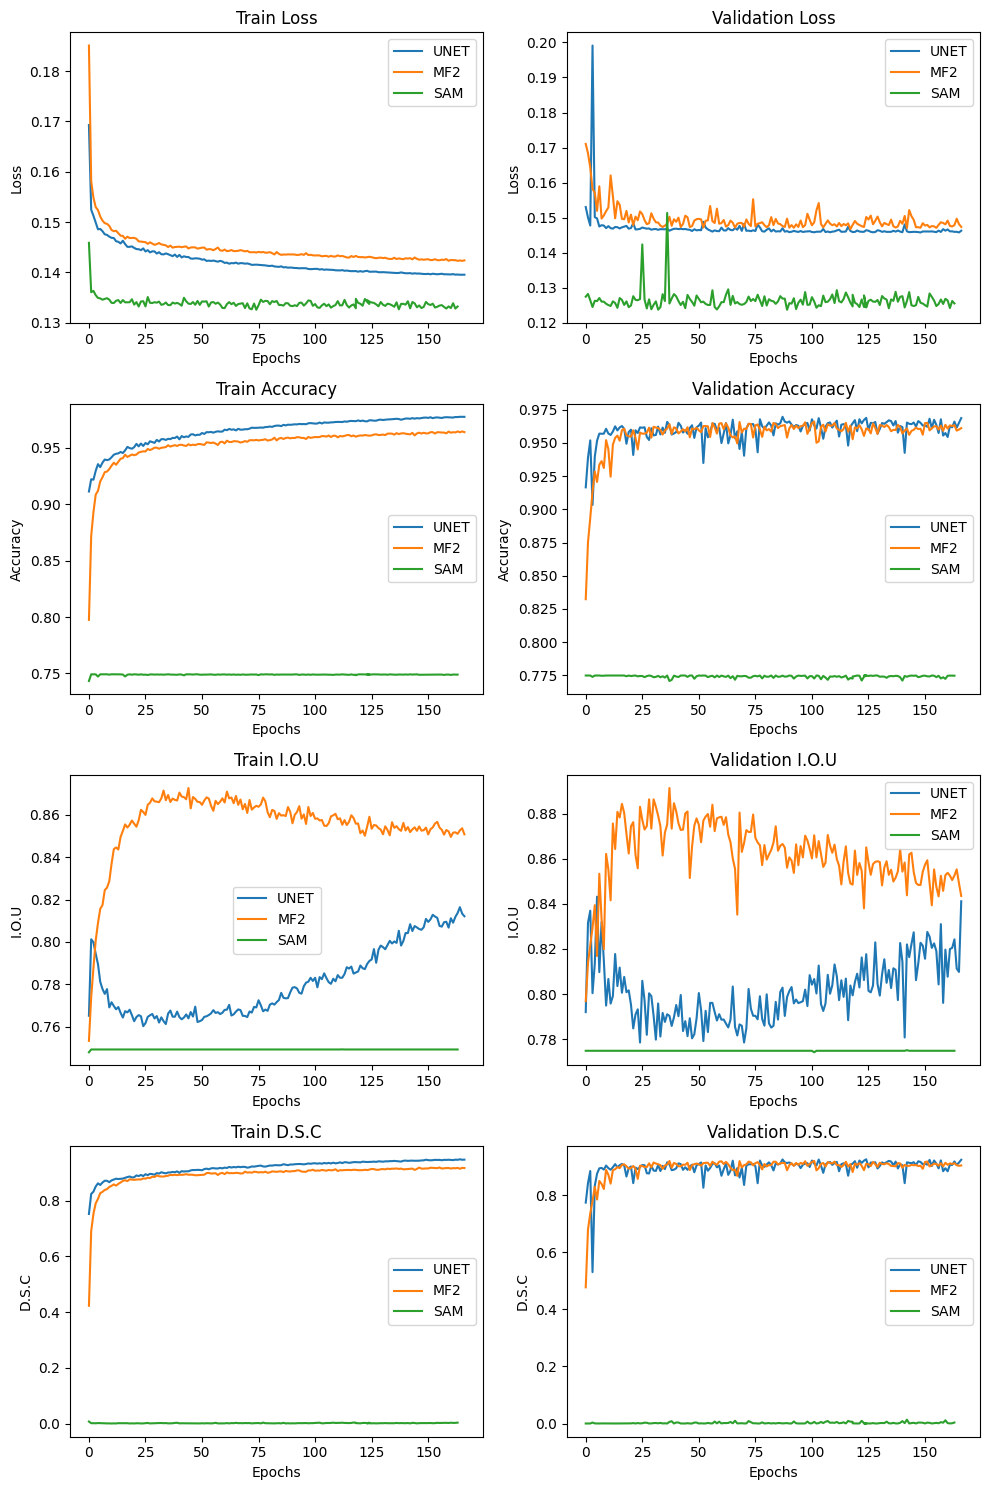

In [ ]:
num_rows = 167
list_df = [df_unet.head(num_rows), df_mf2.head(num_rows), df_sam.head(num_rows)]
list_lagends = ['UNET','MF2','SAM']
list_title_T = ['Train Loss','Train Accuracy','Train I.O.U','Train D.S.C']
list_title_V = ['Validation Loss','Validation Accuracy','Validation I.O.U','Validation D.S.C']
list_data = ['loss','accuracy','io_u','DICE_metric']


fig, axes = plt.subplots(4, 2, figsize=(10, 15))
for ind, col in enumerate(list_data):

  for i,df in enumerate(list_df):
    ax = axes[ind,0]
    y = df[col]
    x = df[df_unet.columns[0]]
    ax.plot(x,y,label = list_lagends[i])
    ax.set_title(list_title_T[ind])
    ax.set_xlabel('Epochs')
    ax.set_ylabel(list_title_T[ind].replace('Train ',''))
    ax.legend()

    ax = axes[ind,1]
    y = df['val_'+ col]
    x = df[df_unet.columns[0]]
    ax.plot(x,y,label = list_lagends[i])
    ax.set_title(list_title_V[ind])
    ax.set_xlabel('Epochs')
    ax.set_ylabel(list_title_T[ind].replace('Train ',''))
    ax.legend()

plt.tight_layout()
plt.show()

**Comparison of all models for validation dataset**

In [ ]:
def DICE_metric(y_true, y_pred):

  y_true = tf.cast(y_true , dtype=tf.double)

  y_pred = tf.cast(y_pred  , dtype=tf.double)

  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  dice = (2.0 * intersection + 1e-5) / (union + 1e-5)

  return dice

In [ ]:
def calcule_metrics(y_truth, y_pred):
  accuracy_metric = tf.keras.metrics.Accuracy()
  IOU_metric = tf.keras.metrics.IoU(num_classes=2,target_class_ids=[0])
  recall_metric = tf.keras.metrics.Recall()
  precision_metric = tf.keras.metrics.Precision()
  F1_metric = tf.keras.metrics.F1Score()


  # accuracy_metric.reset_states()
  # IOU_metric.reset_states()
  # recall_metric.reset_states()
  # precision_metric.reset_states()
  # F1_metric.reset_states()

  DICE_list = []


  for ind, truth in enumerate(y_truth):

    accuracy_metric.update_state(truth, y_pred[ind])
    IOU_metric.update_state(truth, y_pred[ind])
    recall_metric.update_state(truth, y_pred[ind])
    precision_metric.update_state(truth, y_pred[ind])
    F1_metric.update_state(truth, y_pred[ind])

    DICE_list.append(DICE_metric(truth, y_pred[ind]).numpy())

  DICE = mean(DICE_list)

  #, IOU_metric.result().numpy() , recall_metric.result().numpy() , precision_metric.result().numpy() , F1_metric.result().numpy() , DICE


  return accuracy_metric.result().numpy() , IOU_metric.result().numpy() , recall_metric.result().numpy(),precision_metric.result().numpy(), np.mean(F1_metric.result().numpy()) , DICE

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/SAM
!pip install -r requirements.txt

In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/SAM/SAM_WEIGTHS_OTHERS_TRAINING
import sam_path
reload(sam_path)
mask_generator = sam_path.sam_segmentation('./sam_vit_b_01ec64.pth')
y_pred_sam_path = []

for img_to_pre in X_vald_pre:
  new_img = X_vald_pre[y]*255
  image_array = np.array([new_img, new_img, new_img], dtype=np.uint8).transpose(1, 2, 0)
  y_pred_sam_path.append(sam_path.sam_inference(image_array,mask_generator))

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/SAM/SAM_WEIGTHS_OTHERS_TRAINING


In [ ]:
%cd /content/drive/MyDrive/TAREA_4/MODELS/SAM
import sam
from importlib import reload
reload(sam)
%cd /content/drive/MyDrive/TAREA_4/MODELS
y_pred_sam = sam.sam_inference('./TRAIN/SAM/weigths/vit_DSB.pth',X_vald_pre,y_vald)

/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS/SAM
/content/drive/.shortcut-targets-by-id/1Ok8wDDUgPcs04neKZpw4uQWTB7r8hI_Y/TAREA_4/MODELS


In [ ]:
model_unet = tf.keras.models.load_model('./TRAIN/UNET/checkpoints', custom_objects={'DICE_metric': DICE_metric})
model_mf2 = tf.keras.models.load_model('./TRAIN/MF2/checkpoints', custom_objects={'DICE_metric': DICE_metric})

In [ ]:
y_pred_unet = model_unet.predict(X_vald_pre)
y_pred_mf2= model_mf2.predict(X_vald_pre)

3/3 [==============================] - 3s 326ms/step


In [ ]:
y_pred_otsu = []
y_pred_ki = []

for img in X_vald_pre:
  y_pred_otsu.append(otsu_segmentation(img))
  y_pred_ki.append(Kittler_illingwort_segmentation(img))

In [ ]:
y_pred_unet=np.squeeze(y_pred_unet, axis=-1)
y_pred_mf2=np.squeeze(y_pred_mf2, axis=-1)

In [ ]:
y_pred_sam = np.array(y_pred_sam)
y_pred_sam_path = np.array(y_pred_sam_path)
y_pred_otsu= np.array(y_pred_otsu)
y_pred_ki = np.array(y_pred_ki)

In [ ]:
print(y_pred_unet.shape,y_pred_mf2.shape,y_pred_sam.shape,y_pred_sam_path.shape,y_pred_otsu.shape,y_pred_ki.shape)

(67, 128, 128) (67, 128, 128) (67, 128, 128) (67, 128, 128) (67, 128, 128) (67, 128, 128)


In [ ]:
accurac_unet, IOU_unet, recall_unet, precision_unet, F1_unet, DSC_unet = calcule_metrics(y_vald, y_pred_unet)
accurac_mf2, IOU_mf2, recall_mf2, precision_mf2, F1_mf2, DSC_mf2 = calcule_metrics(y_vald, y_pred_mf2)
accurac_sam, IOU_sam, recall_sam, precision_sam, F1_sam, DSC_sam = calcule_metrics(y_vald, y_pred_sam)
accurac_sam_path, IOU_sam_path, recall_sam_path, precision_sam_path, F1_sam_path, DSC_sam_path = calcule_metrics(y_vald, y_pred_sam_path)
accurac_otsu, IOU_otsu, recall_otsu, precision_otsu, F1_otsu, DSC_otsu = calcule_metrics(y_vald, y_pred_otsu)
accurac_ki, IOU_ki, recall_ki, precision_ki, F1_ki, DSC_ki = calcule_metrics(y_vald, y_pred_ki)

In [ ]:
data = {
    'Modelo': ['UNet', 'MF2', 'SAM','SAM Pathology', 'OTSU', 'KI'],
    'Accuracy': [accurac_unet, accurac_mf2, accurac_sam, accurac_sam_path, accurac_otsu, accurac_ki],
    'IOU': [IOU_unet, IOU_mf2, IOU_sam,IOU_sam_path, IOU_otsu, IOU_ki],
    'Recall': [recall_unet, recall_mf2, recall_sam,recall_sam_path, recall_otsu, recall_ki],
    'Precision': [precision_unet, precision_mf2, precision_sam, precision_sam_path,precision_otsu, precision_ki],
    'F1 Score': [F1_unet, F1_mf2, F1_sam, F1_sam_path,F1_otsu, F1_ki],
    'DSC': [DSC_unet, DSC_mf2, DSC_sam,DSC_sam_path, DSC_otsu, DSC_ki]
}


df_models = pd.DataFrame(data)
df_models

,Modelo,Accuracy,IOU,Recall,Precision,F1 Score,DSC
0,UNet,0.126610,0.870662,0.889647,0.969025,0.654978,0.933848
1,MF2,0.107608,0.865344,0.888247,0.939818,0.637166,0.926893
2,SAM,0.774650,0.774629,0.000405,0.248756,0.000797,0.000822
3,SAM Pathology,0.755659,0.753668,0.035894,0.228701,0.054267,0.060627
4,OTSU,0.819140,0.810500,0.202495,0.972506,0.335059,0.288634
5,KI,0.274400,0.063641,0.999636,0.236781,0.382448,0.358862


**Inference**

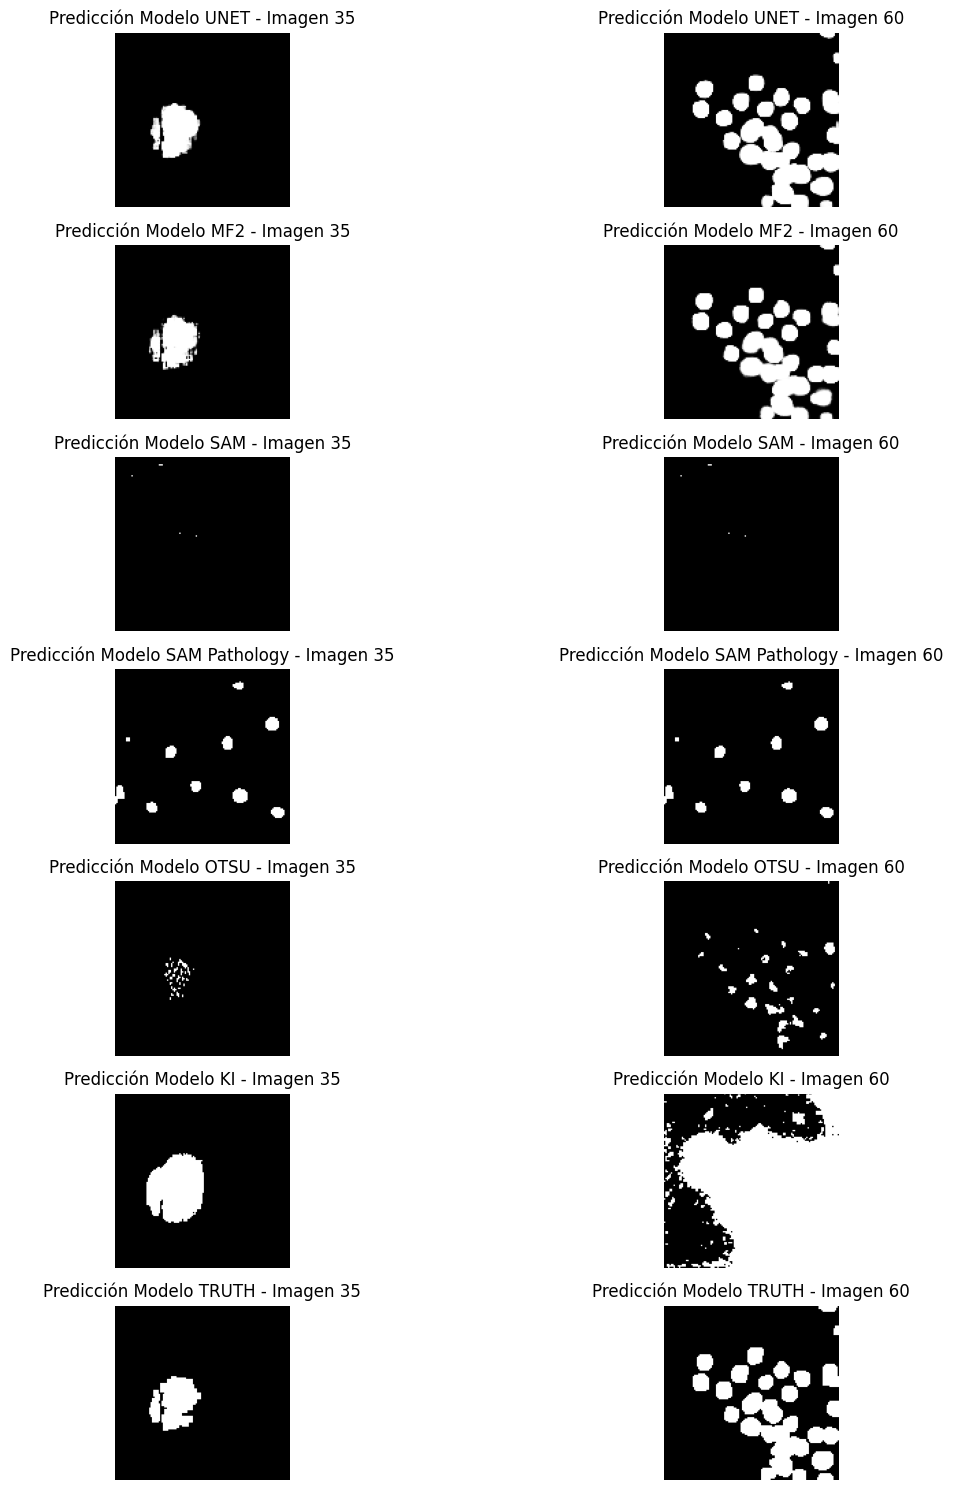

In [ ]:
import random
y_pred_matrices = [y_pred_unet, y_pred_mf2, y_pred_sam,y_pred_sam_path, y_pred_otsu, y_pred_ki,y_vald]
y_models_labels = ['UNET','MF2','SAM','SAM Pathology','OTSU','KI','TRUTH']

fig, axes = plt.subplots(7, 2, figsize=(15, 15))

for j in range(2):
  rand = random.randint(1, 67)

  for i, y_pred in enumerate(y_pred_matrices):
    axes[i, j].imshow(y_pred[rand], cmap='gray')
    axes[i, j].set_title(f'Predicción Modelo {y_models_labels[i]} - Imagen {rand}')
    axes[i, j].axis('off')


plt.tight_layout()

plt.show()